In [1]:
from src import data_setup, engine, utils, models
from importlib import reload

[reload(m) for m in (data_setup, engine, utils, models)]
device = engine.initialize()

[CONNECTED] NVIDIA GeForce RTX 3070


In [2]:
import torch
from torchvision.datasets import OxfordIIITPet as SET
from torchvision.transforms import ToTensor, Compose, Resize, TrivialAugmentWide
from matplotlib import pyplot as plt
from pathlib import Path

class ToDevice:
    def __init__(self):
        self.device = device
    def __call__(self, x):
        return x.to(self.device)

IMG_SIZE = 64
transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    TrivialAugmentWide(num_magnitude_bins=8),
    ToTensor(), lambda x: x*2 - 1,
    ToDevice()])

data_dir = Path('data')
torch.set_default_device(device)
args_list = [{'root': data_dir, 'split': s, 'transform': transform, 'download': True} for s in ('trainval', 'test')]
data = [SET(**args) for args in args_list]
data

[Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: data
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                <function <lambda> at 0x7f6e6613b760>
            ),
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: data
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                <function <lambda> at 0x7f6e6613b760>
            )]

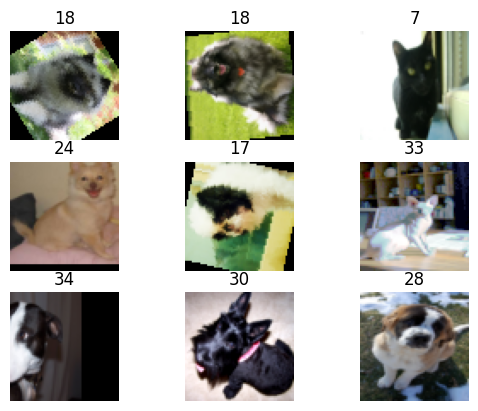

In [3]:
from torch.utils.data import DataLoader
loader = DataLoader(data[0], shuffle=True, generator=torch.Generator(device='cuda'))
utils.visualize(loader, 9, transform=lambda x: (x+1)/2)

### Diffusion Model Steps:
1. The forward process = Noise Schedular
2. The backward process = U-Net
3. The loss

### Noise Schedular

In [187]:
from torch.nn import functional as F
def linear_beta_schedule(timesteps, start=1e-4, end=2e-2):
    return torch.linspace(start, end, timesteps)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
# Next step at t
#   = q( x_t │ x_(t-1) )
#   = N(x_t, √(1-β)*x_(t-1), β_t*I)
#   = √(1-β_t)*x_(t-1) + √(β_t)*ϵ
#   = √(α_t)*x_(t-1) + √(1-α_t)*ϵ

# Need sqrt_alpha_t & sqrt_one_minus_alpha_t
# α_t = ∏_(s=1)^(t) (a_s)
# sqrt_alpha_t = sqrt_alphas_cumprod = √(α_t)
# sqrt_one_minus_alpha_t = sqrt_one_minus_alphas_cumprod = √(1-α_t) = √(1-β_t)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas = torch.sqrt(alphas_cumprod)
sqrt_betas = torch.sqrt(1. - alphas_cumprod)

# dunno yet why do I need this
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [188]:
def get_index_from_list(
        vals: torch.Tensor, t: torch.Tensor, x_shape: torch.Size
):
    """
    :param vals: torch vector
    :param t: Diffusion timestep. Shape -> (1)
    :param x_shape: batch shape
    :return:
        A specific index t of a passed list of values vals
        while considering the batch dimension.
    """

    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *( (1,) * (len(x_shape)-1) )).to(t.device)

def map_x(x, a0, a1):
    x_min, x_max = x.min(), x.max()
    return  (x - x_min) * ( (a1 - a0) / (x_max - x_min) ) + a0

def forward_diffusion_sample(x_0: torch.Tensor, t: torch.Tensor):
    """
    :param x_0: Original Image. Shape -> (c, h, w)
    :param t: Diffusion timestep. Shape -> (1)
    :return: The noisy version of x_0 at t
    """

    noise = torch.randn_like(x_0)  # Normal distribution ~ mu=0, var=1
    sqrt_alpha_t = get_index_from_list(sqrt_alphas, t, x_0.shape)
    sqrt_beta_t = get_index_from_list(sqrt_betas, t, x_0.shape)

    # x_t = sqrt(a)*x_0 + sqrt(1-a)*ε
    x_t = sqrt_alpha_t*x_0 + sqrt_beta_t*noise

    # Experimental
    x_t = map_x(x_t, -1, 1)
    return x_t, noise

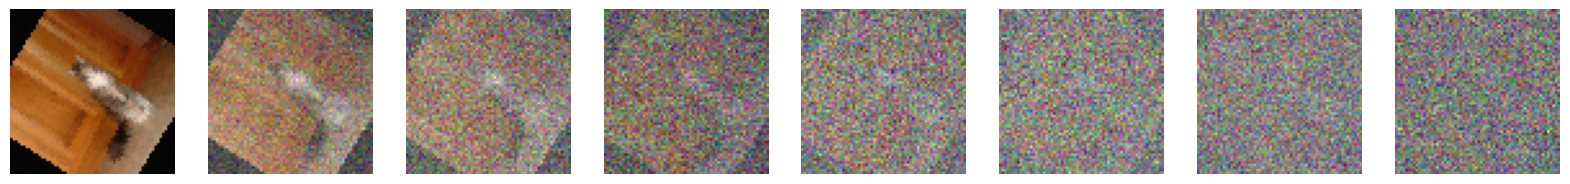

In [189]:
# demo
plt.figure(figsize=(20, 10))
x_0 = next(iter(loader))[0][0]
n = 7
steps = range(0, T, int(T/n))
for i, step in enumerate(steps):
    t = torch.tensor([step], dtype=torch.int64, device=device)
    x_t, _ = forward_diffusion_sample(x_0, t)

    img = (x_t.detach().cpu().permute(1,2,0)+1)/2

    plt.subplot(1, n+1, i+1)
    plt.imshow(img)
    plt.axis('off')

### U-Net

In [191]:
t = torch.tensor(steps, dtype=torch.int64, device=device)
t

tensor([  0,  42,  84, 126, 168, 210, 252, 294], device='cuda:0')